# IoT Intrusion Detection [Keylogging]

# Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn import metrics
import keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adam

# Reading Data

In [ ]:
df_dk=pd.read_csv('/content/drive/MyDrive/IOT_Cuối Kỳ/Keylogger_Detection.csv')
df_dk.head(5)

<ipython-input-23-94a8d6cabfab>:1: DtypeWarning: Columns (48,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dk=pd.read_csv('/content/drive/MyDrive/IOT_Cuối Kỳ/Keylogger_Detection.csv')


,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
0,0,10.42.0.211-52.6.25.230-34451-443-6,10.42.0.211,34451.0,52.6.25.230,443.0,6.0,04/08/2017 05:12:36,12140931.0,9.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,1,172.217.3.99-10.42.0.151-443-53892-6,10.42.0.151,53892.0,172.217.3.99,443.0,6.0,04/08/2017 07:55:51,418882.0,102.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,2,172.217.3.98-10.42.0.151-443-50750-6,172.217.3.98,443.0,10.42.0.151,50750.0,6.0,04/08/2017 08:48:19,45.0,2.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,3,10.42.0.211-10.42.0.1-23025-53-17,10.42.0.211,23025.0,10.42.0.1,53.0,17.0,04/08/2017 05:54:10,541699.0,1.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,4,10.42.0.211-123.129.244.226-52602-443-6,10.42.0.211,52602.0,123.129.244.226,443.0,6.0,04/08/2017 08:44:25,7310795.0,3.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


# Data Preprocessing

In [ ]:
df_dk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523617 entries, 0 to 523616
Data columns (total 86 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    523617 non-null  int64  
 1   Flow ID                       523610 non-null  object 
 2    Source IP                    523617 non-null  object 
 3    Source Port                  523617 non-null  float64
 4    Destination IP               523617 non-null  object 
 5    Destination Port             523617 non-null  float64
 6    Protocol                     523617 non-null  float64
 7    Timestamp                    523617 non-null  object 
 8    Flow Duration                523617 non-null  float64
 9    Total Fwd Packets            523617 non-null  float64
 10   Total Backward Packets       523617 non-null  float64
 11  Total Length of Fwd Packets   523617 non-null  float64
 12   Total Length of Bwd Packets  523617 non-nul

In [ ]:
Class_df = df_dk["Class"]
df_num = df_dk.select_dtypes(include=[np.number])
df_num = df_num.join(Class_df)

In [ ]:
df_num.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# Giá trị NaN là một giá trị của kiểu dữ liệu số, biểu diễn một giá trị không xác định hoặc không thể biểu diễn. Nó thường gặp trong các phép tính dấu phẩy động.
# Một số trường hợp có thể sinh ra NaN bao gồm:
# Lấy số 0 chia cho số 0.
# Lấy vô cùng (infinity) chia cho vô cùng (infinity).
# Nhân vô cùng (infinity) với số 0.
# Chuyển đổi một xâu non-numeric hoặc undefined về dạng number.
print(df_num.isna().sum().sum())
df_num=df_num.dropna()

879


In [ ]:
df_num["Class"].value_counts()

Benign       308813
Keylogger    214782
Name: Class, dtype: int64

In [ ]:
df_num["label"]=df_num["Class"]
df_num.loc[df_num.label == "Benign", 'label'] = 0
df_num.loc[df_num.label == "Keylogger", 'label'] = 1
df_num.drop('Class', axis=1, inplace=True)
df_num.sample(5)

<ipython-input-29-c10bc1f6f8fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num["label"]=df_num["Class"]


,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
156275,47957.0,80.0,6.0,10580260.0,3.0,1.0,0.0,0.0,0.0,0.0,...,20.0,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1
283706,33244.0,443.0,6.0,2835323.0,128.0,163.0,3316.0,218258.0,816.0,0.0,...,32.0,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0
480497,49976.0,80.0,6.0,10665593.0,4.0,3.0,262.0,141.0,262.0,0.0,...,32.0,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0
321497,31079.0,53.0,17.0,262691.0,1.0,1.0,33.0,81.0,33.0,33.0,...,32.0,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1
312817,52890.0,443.0,6.0,72388386.0,19.0,17.0,3393.0,4703.0,1398.0,0.0,...,32.0,128025.5,24135.675762,145092.0,110959.0,36066146.0,4.085039e+07,64951736.0,7180556.0,0


In [ ]:
df_num["label"].value_counts()

0    308813
1    214782
Name: label, dtype: int64

In [ ]:
# Duyệt qua tất cả các cột trong df_num và xóa các cột chỉ chứa một giá trị duy nhất.
for col in (df_num.iloc[:,:-1].columns):
    if(df_num[col].min()==df_num[col].max()):
            df_num.drop(col, axis=1, inplace=True)

In [ ]:
# Normalization OR Standardization
def standardize(df,col):
    df[col]= (df[col]-df[col].mean())/(df[col].std()) # Standardization

for i in (df_num.iloc[:,:-1].columns):
    standardize(df_num,i)

df_num.head()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,-0.210447,-0.368579,-0.468868,0.042412,-0.004811,-0.036722,-0.013233,-0.038629,-0.021233,-0.212203,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0
1,0.828487,-0.368579,-0.468868,-0.465677,0.945480,0.575336,-0.004001,0.556642,0.815442,-0.212203,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0
2,-2.027848,2.839488,-0.468868,-0.483831,-0.076338,-0.055364,-0.018437,-0.046536,-0.435509,-0.212203,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0
3,-0.821057,-0.393449,2.036972,-0.460353,-0.086556,-0.052257,-0.018736,-0.046050,-0.478832,0.522899,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0
4,0.759549,-0.368579,-0.468868,-0.166949,-0.066120,-0.055364,-0.019463,-0.046536,-0.584432,-0.212203,...,0.004135,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0


In [ ]:
target=['label']
features = [c for c in df_num.columns if c!="label"]

# Split DataSet

In [ ]:
X = df_num[features].values # Features
y = df_num[target].values # Target

X=X.astype(np.float32)
y=y.astype(np.float32)

X.shape,y.shape,

((523595, 67), (523595, 1))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(x_train.shape)
print(x_test.shape)

(418876, 67)
(104719, 67)


In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_train_res, y_train_res = ros.fit_resample(x_train, y_train)

In [ ]:
x_train_cnn = np.reshape(x_train_res, (x_train_res.shape[0], x_train_res.shape[1],1))
x_test_cnn = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
print(x_train_cnn.shape)
print(x_test_cnn.shape)

(494000, 67, 1)
(104719, 67, 1)


# Build CNN Model

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape = (X.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(filters=128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(filters=256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(filters=512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

adam = keras.optimizers.legacy.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 67, 64)            384       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 33, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 33, 128)           41088     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 16, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 16, 256)           164096    
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 8, 256)           

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001,
                           patience = 50, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.75,
                              patience = 10, min_delta = 0.001,
                              mode = 'min', verbose = 1)
csv_logger = CSVLogger('/content/drive/MyDrive/IOT_Cuối Kỳ/history.csv')

epochs = 100
batch_size = 512
history = model.fit(x_train_cnn,y_train_res, batch_size=batch_size,
    steps_per_epoch=x_train_res.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test_cnn,y_test),
    callbacks=[early_stop, reduce_lr, csv_logger])

Epoch 1/100
964/964 [==============================] - 21s 21ms/step - loss: 0.6613 - accuracy: 0.5830 - val_loss: 0.6482 - val_accuracy: 0.6024 - lr: 0.0010
Epoch 2/100
964/964 [==============================] - 23s 23ms/step - loss: 0.6374 - accuracy: 0.6071 - val_loss: 0.6265 - val_accuracy: 0.6325 - lr: 0.0010
Epoch 3/100
964/964 [==============================] - 20s 21ms/step - loss: 0.6221 - accuracy: 0.6209 - val_loss: 0.6137 - val_accuracy: 0.6353 - lr: 0.0010
Epoch 4/100
964/964 [==============================] - 20s 21ms/step - loss: 0.6084 - accuracy: 0.6349 - val_loss: 0.6055 - val_accuracy: 0.6480 - lr: 0.0010
Epoch 5/100
964/964 [==============================] - 21s 22ms/step - loss: 0.5957 - accuracy: 0.6462 - val_loss: 0.5901 - val_accuracy: 0.6525 - lr: 0.0010
Epoch 6/100
964/964 [==============================] - 20s 21ms/step - loss: 0.5830 - accuracy: 0.6594 - val_loss: 0.5779 - val_accuracy: 0.6722 - lr: 0.0010
Epoch 7/100
964/964 [==============================]

In [ ]:
model.save('/content/drive/MyDrive/IOT_Cuối Kỳ/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Training Curves

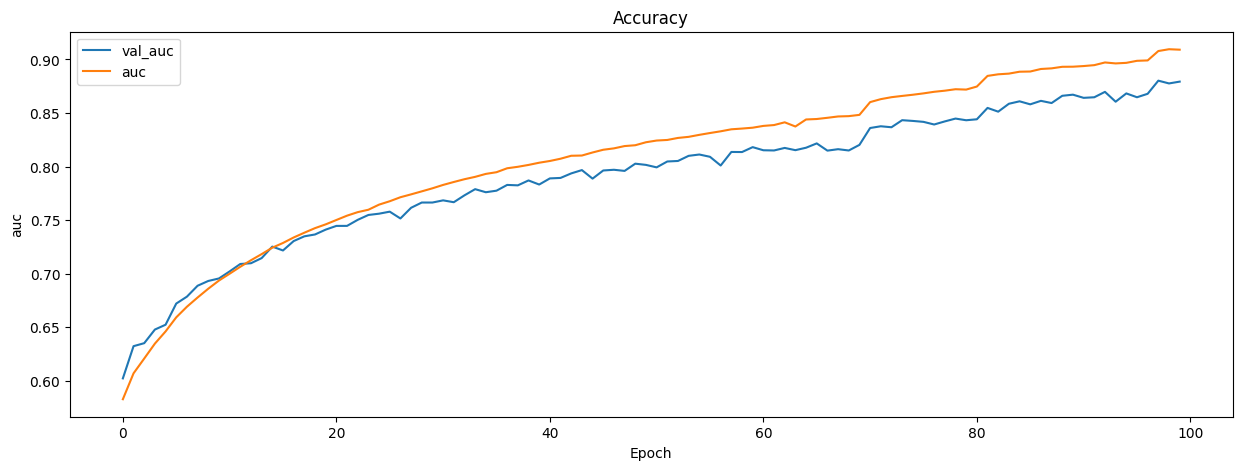

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_accuracy'],label='val_auc')
plt.plot(range(history.epoch[-1]+1),history.history['accuracy'],label='auc')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('auc');plt.legend();
plt.show()

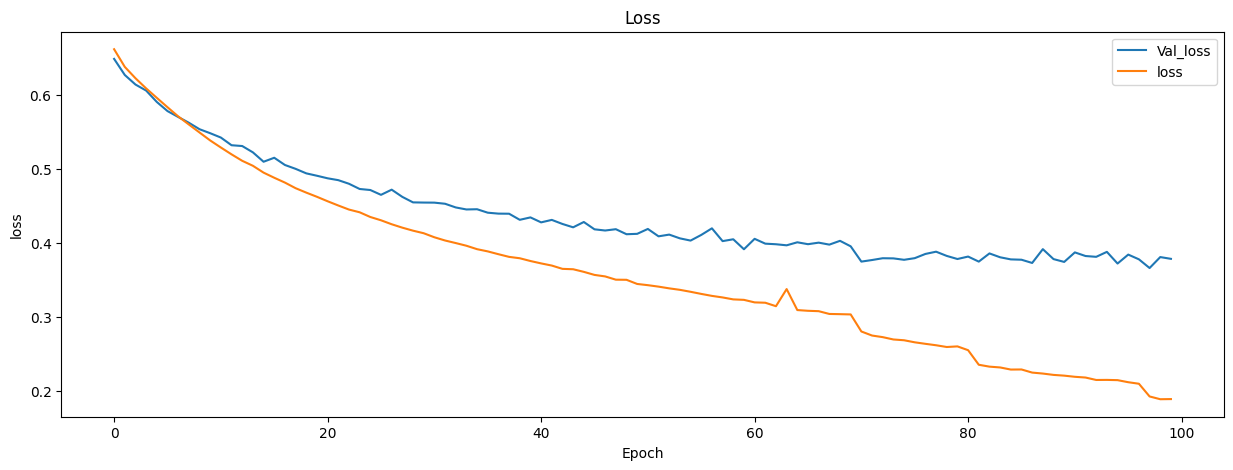

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='loss')
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend();
plt.show()

# Evaluation

205/205 [==============================] - 1s 6ms/step
Accuracy: 0.88
Precision: 0.84
Recall: 0.87 

              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90     61813
         1.0       0.84      0.87      0.86     42906

    accuracy                           0.88    104719
   macro avg       0.87      0.88      0.88    104719
weighted avg       0.88      0.88      0.88    104719

Confusion matrix: 
 [[54656  7157]
 [ 5484 37422]]


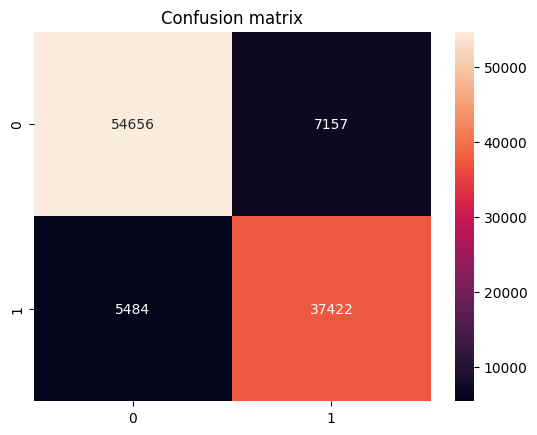

In [ ]:
p_pred = model.predict(x_test_cnn, batch_size = 512)
p_pred = p_pred.flatten()
y_pred = np.where(p_pred > 0.5, 1, 0)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", format(accuracy, ".2f"))
print("Precision:", format(precision, ".2f"))
print("Recall:", format(recall, ".2f"), '\n')

print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix: \n', confusion_matrix)
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.show()

# ROC Curve

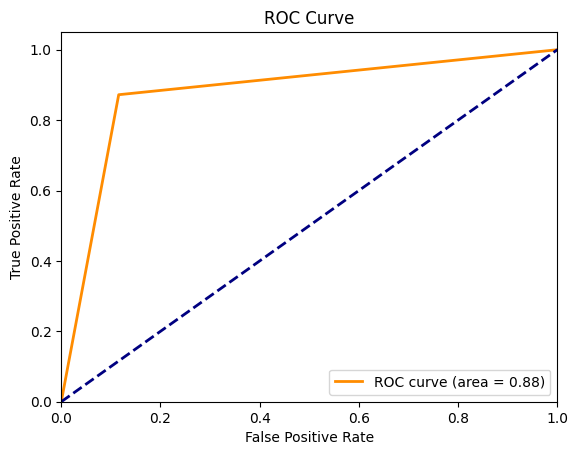

In [ ]:
def generate_results(y_test, y_score):
    # print(y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

generate_results(y_test, y_pred)